In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np


from ShapeDescs import *
from utils import plot_sample_cluster, cluster_sizes

In [3]:
#get the datapath
datapath = Path.cwd().parent / '316L-reused' / '316L-reused' / 'Individual Particle Images'
datapath

WindowsPath('c:/Users/eakew/OneDrive - Trinity College Dublin/Documents/Research Work/ShapeAnalysisForMgPowder/316L-reused/316L-reused/Individual Particle Images')

# Clustering Extracted Morphometric Data

In [4]:
# import the choice of Shape descriptor for extracting morphological features from the images. Using Fourier Descriptors for this tutorial.
from ShapeDescs import FourierDescriptor

In [5]:
Descriptor = FourierDescriptor(datapath = datapath, num_pairs= 5, ext = '.bmp')
Descriptor.get_descs() #computes the FD features. The 'get_descs()' method does same for all shape descriptor implemented in ShapeSecs

In [6]:
fd_features = Descriptor.descs #obtain the FD features array
fd_features.shape

(125873, 10)

## Multivariate Clustering: kmeans & GMM

Python modules `select_kmeans` and `select_gmm` implements clustering via kmeans and GMM respectively, together with corresponding techniques for model selection. For Kmeans, a silhouette analysis was implemented, while for GMM an heuristic BIC/AIC technique was implemented. This analyses were also complemented with Davies-Bouldin clustering validation score to decide on model selection - which is essentially choosing the number of clusters for each method. Using these multivariate clustering are illustrated below:

### Kmeans

In [7]:
from select_kmeans import silhouette_analysis, silhouette_analysis_parallel

Starting parallel K-means clustering...


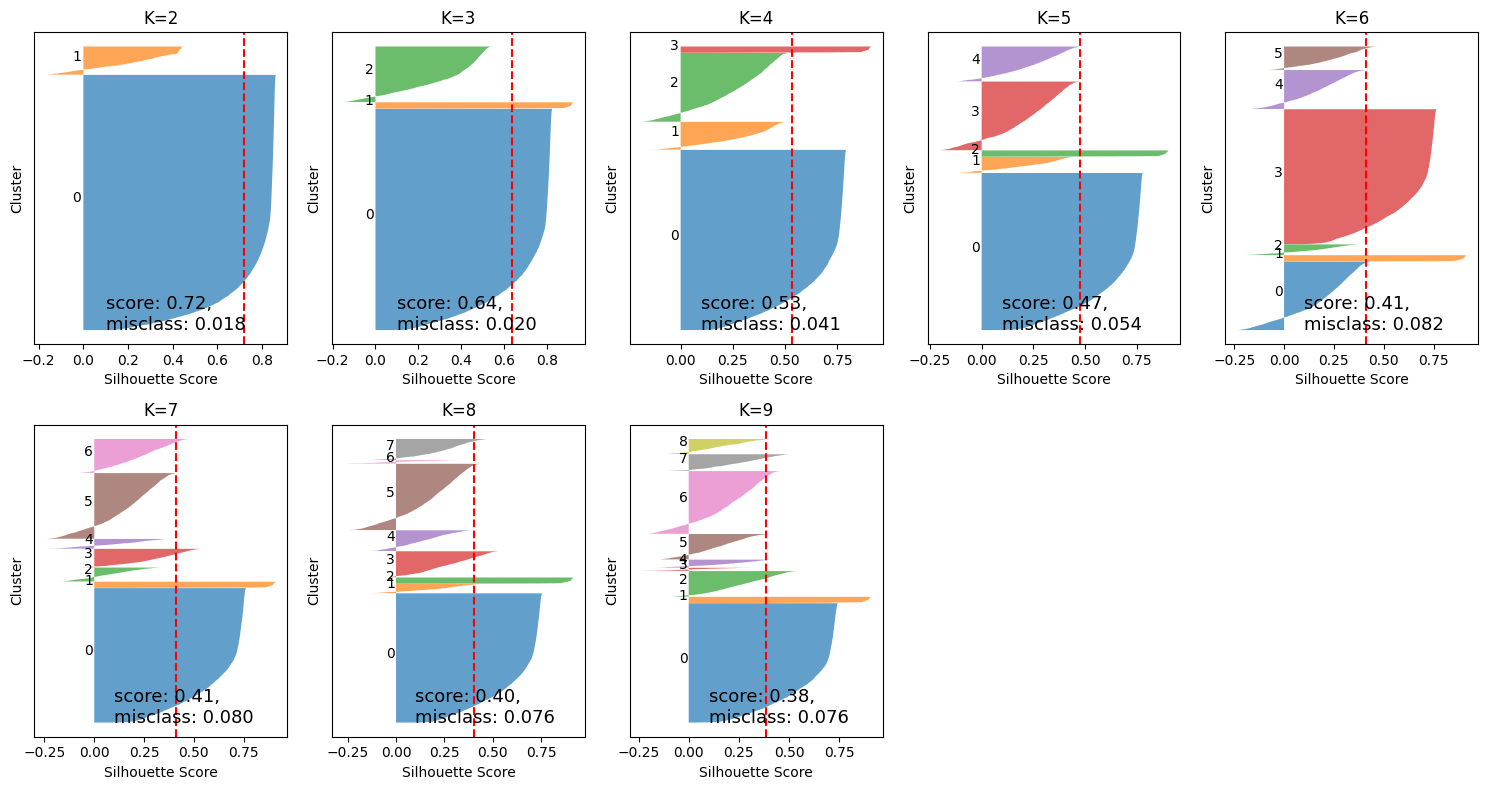

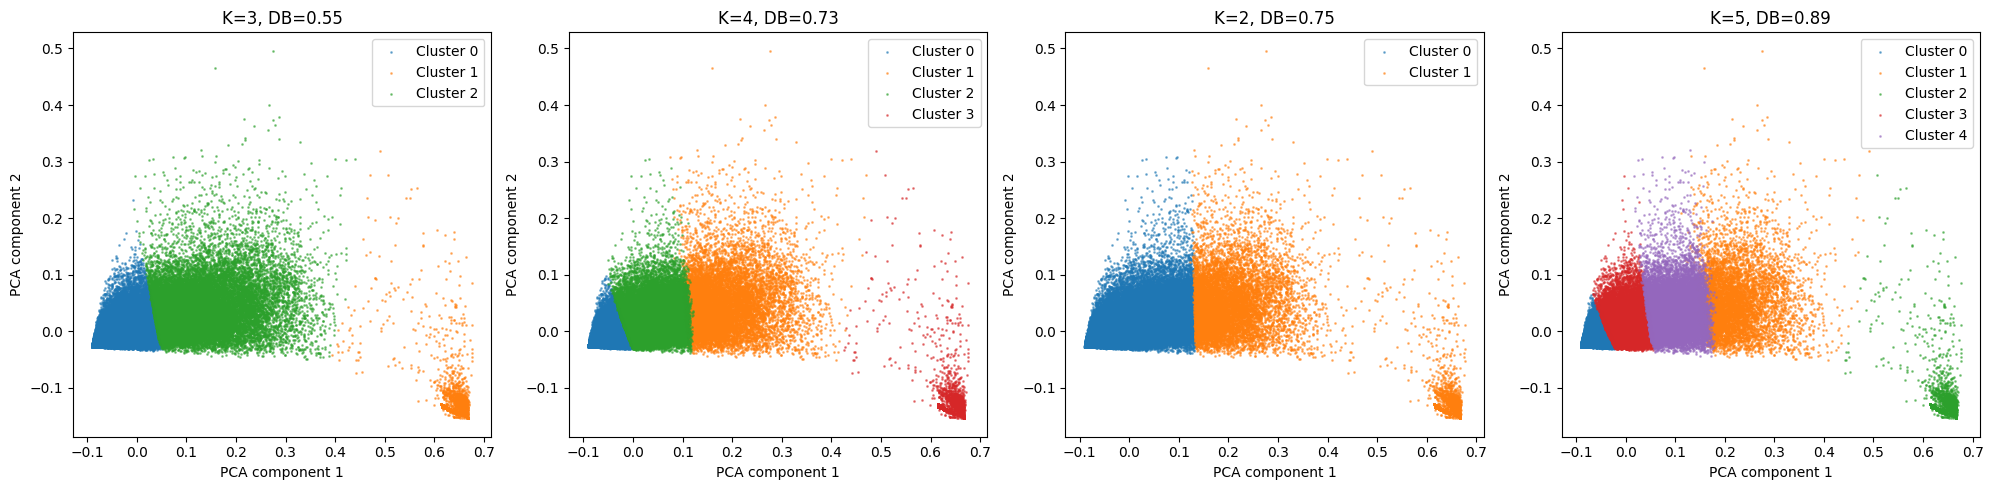

In [8]:
lbls, dbs = silhouette_analysis_parallel( #can also use silhouette_analysis, difference is that this version runs computations in parallel and hence faster.
    X= fd_features,
    k_min= 2,
    k_max= 9,
    n_jobs= 8
)

The first image consists of silhouette plots, showing the distribution of silhouette coefficient of each shape. The avaerage silhouette score and the proportion of misclassification is also printed on each plot. Although K=2 has the highest silhouette score, the clustering is of least value as depicted in the PCA clustering visualization plot in the second image. In the second image, we observe that K=3 is judged to be the best clustering based on Davies-Bouldin index (DB). Observe that silhouette score of all the shapes in cluster 1 of clustering (k=2) are very well below the average (depicted by the red dash line). The same can be said about the cluster 2 of clustering (K= 3). A better choice is to settle for clustering (K = 4) or (K = 5). Observe tgat the Silhouette scores begins to reduces at a slower pace after clustering (K= 5), but the DB score for clustering (K =5) is worse (higher) than that of clustering (K = 5). We shall choose clustering (K = 4)

All the labels are stored in `lbls` which was returned by `silhouette_analysis_parallel`. Further, we can extract more information about the clustering  (K = 4) as shown below.

In [9]:
lbl4 = lbls[2]# clustering K = 4 i indexed as 2 in lbls. recall we analysed for K = 2, 3, 4, ..., 9
np.unique(lbl4) # to confirm there are exactly the desired number of clusters (4)

array([0, 1, 2, 3])

In [10]:
from utils import cluster_sizes, plot_sample_cluster, plot_trad_desc

In [11]:
# To see the size of each cluster
cluster_sizes(lbl4, prop= False) # set `prop` to True to obtain size as proportions

array([80162, 12349, 30567,  2795])

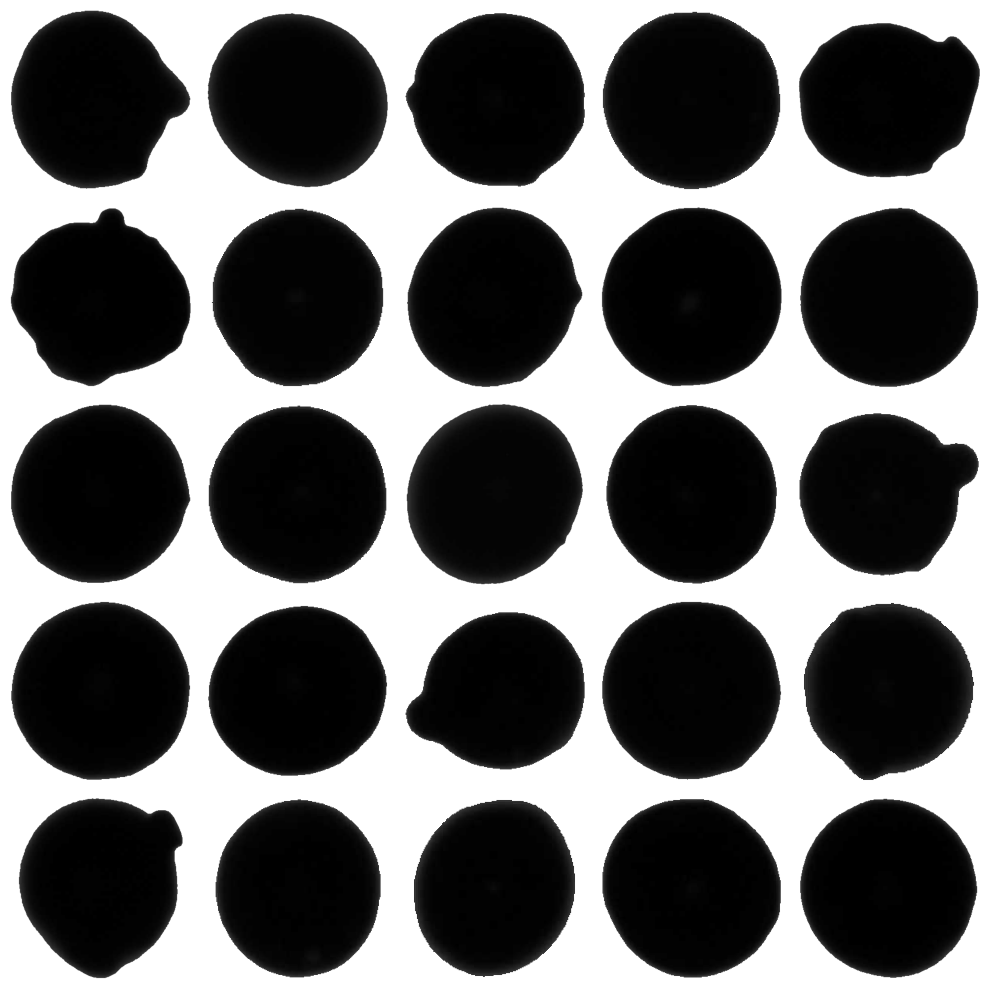

In [12]:
# to plot random members from a specific cluster
plot_sample_cluster(datapath=datapath, #path to powder shape images
                    labels= lbl4, #label array or list
                    n = 0, #label of cluster to plot
                    n_plots= (5,5) # size of plot (number of rows, number of columns). 
                    )

Could not extract ID from filename: 0719_316L_3_2240-CE diameter=66.60.bmp (invalid literal for int() with base 10: '2240-CE diameter=66.60')


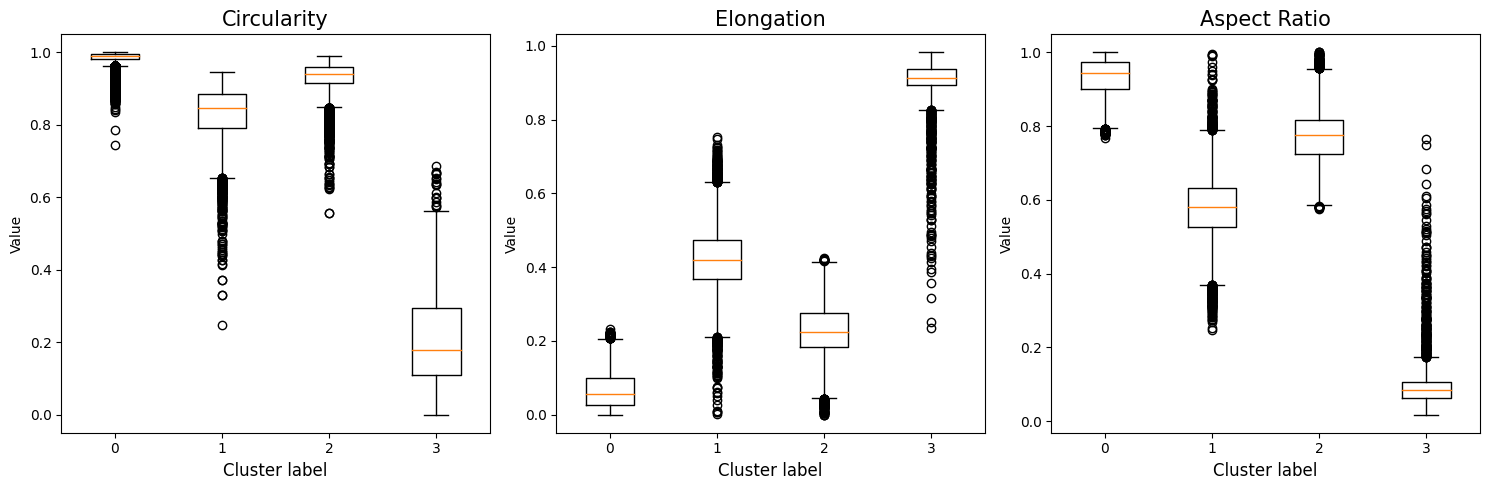

In [13]:
# show the distribution of morphological characteristics each cluster
plot_trad_desc(
    label_path= lbl4,
    datapath= datapath,
    trad_desc= Path.cwd().parent / '316L-reused' / '316L-reused' / 'test-3 Particles.txt' #path to morphological characteristics measured by Morphologi4
)

### GMM

In [14]:
from select_gmm import gmm_analysis_parallel, gmm_analysis

Starting parallel GMM analysis...


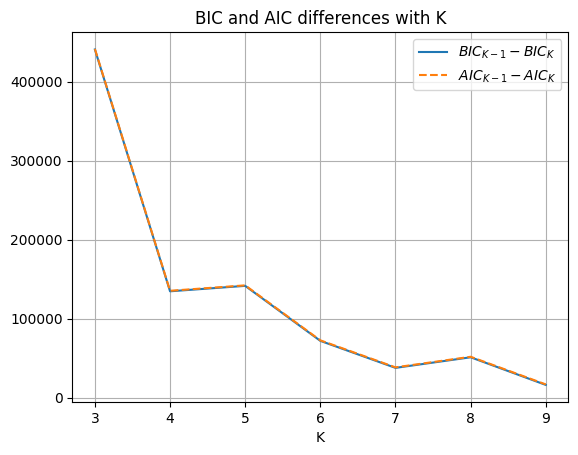

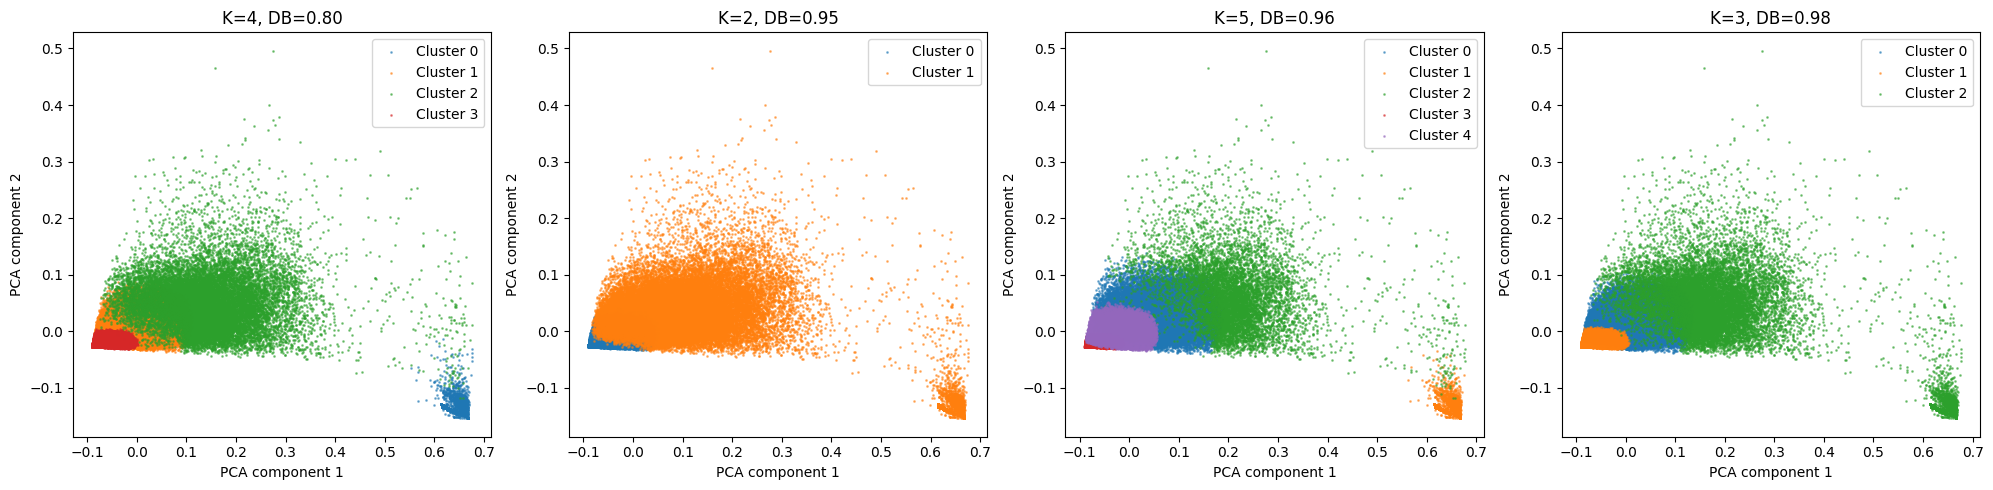

In [15]:
lbls_gmms, db_gmms = gmm_analysis_parallel( #can also use gmm_analysis, difference is that this version runs computations in parallel and hence faster.
    X= fd_features,
    k_min = 2,
    k_max= 9,
    n_jobs= 8
)

BIC and AIC are popular criterion for GMM model selection. In this study, it was observed that these criteria keep reducing as more and more number of components are introduced, make model selection challenging. An heuristic elbow method was deviced to identify the point at which BIC and/or AIC differential slows down. This point is then selected as a potential optimal number of components for the problem. We also try to justify the selections with internal cluster validation index, DB.

In the illustration, K = 4 is the elbow of the difference curve. This choice of clustering is also supported by DB. K=4 has the least DB of all number of components considered in this experiment.

Similar analysis as show with Kmeans can also be carried out with this GMM clustering. We only show one of the analysis for distribution of morphological characteristics of each cluster:

Could not extract ID from filename: 0719_316L_3_2240-CE diameter=66.60.bmp (invalid literal for int() with base 10: '2240-CE diameter=66.60')


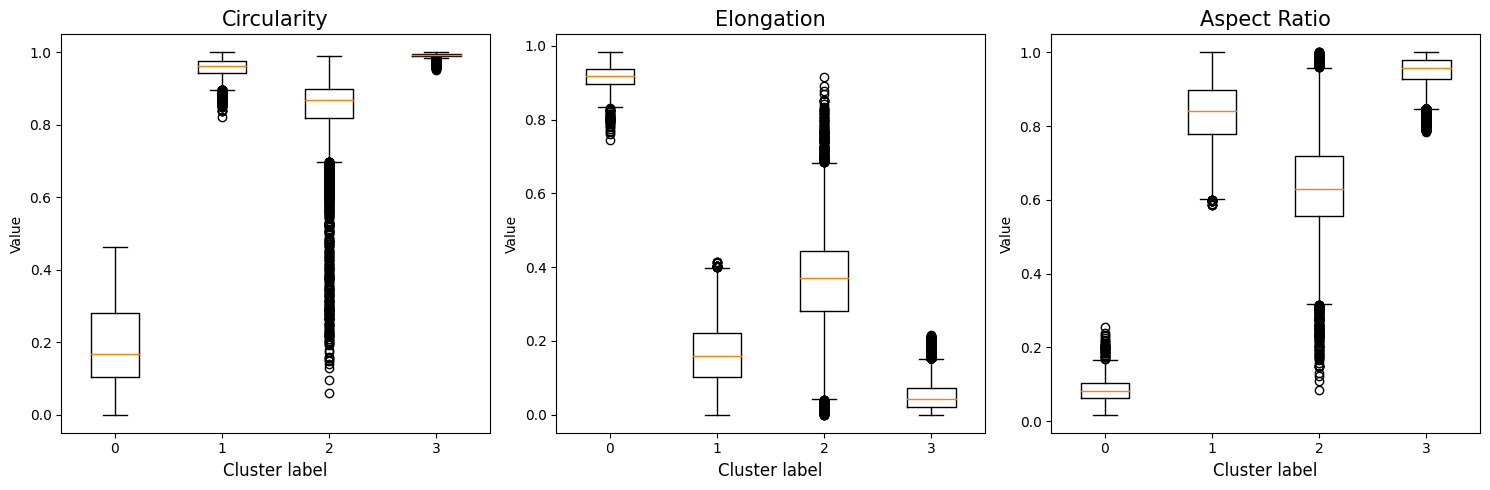

In [16]:
# show the distribution of morphological characteristics each cluster
plot_trad_desc(
    label_path= lbls_gmms[2],
    datapath= datapath,
    trad_desc= Path.cwd().parent / '316L-reused' / '316L-reused' / 'test-3 Particles.txt' #path to morphological characteristics measured by Morphologi4
)

# Clustering VAE Embedings

In [17]:
from O2VAE_encoding import autoencoding

In [ ]:
o2vae_embeddings = autoencoding() #If config json is different from 'O2VAE_encoding_config.json', pass the correct config to the `config` argument.
o2vae_embeddings.shape

(125873, 64)

Having obtained the VAE embeddings, the Kmeans and GMM clustering can be obtained with functions `silhouette_analysis_parallel`and `gmm_analysis_parallel` described earlier in the tutorial. We shall illustrate GMM clustering below.

Note: Because the o2vae embeddings are 64 dimensional, the GMM analysis starts by reducing the dimensionality to 20 so as to reduce computation involve in working with the large covariance matrices.

Starting parallel GMM analysis...


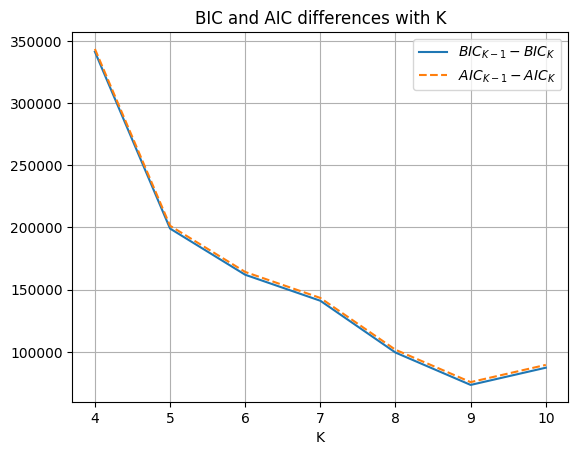

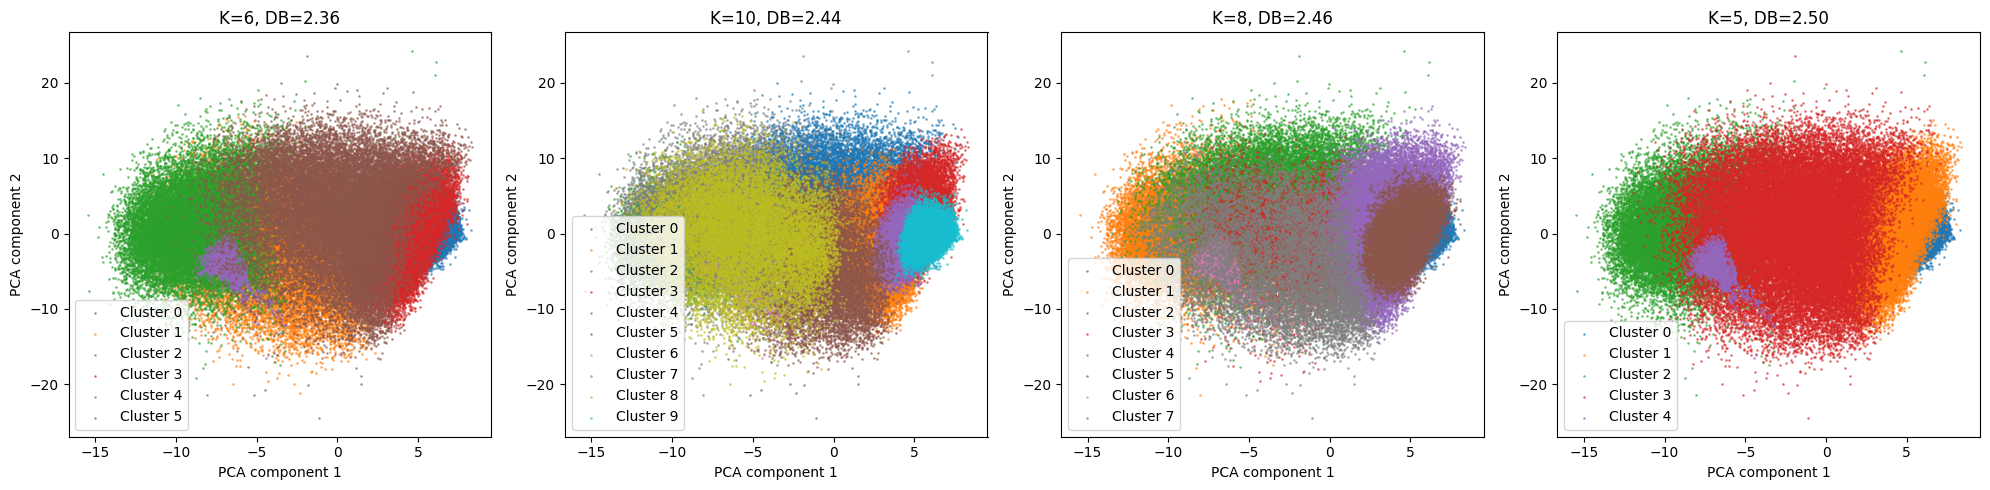

In [39]:
lbls_vae, dbs_vae = gmm_analysis_parallel(
    X = o2vae_embeddings,
    k_min= 3,
    k_max = 10,
    n_jobs = 8
)

In addition to the above analysis, the Calinski-Harabasz score can also be considered in selecting the number of clusters. CH proposes that the higher the CH score, the better the clustering. A wrapper of the calinsi-harabasz_score can be imported from the `utils.py` module.

In [40]:
from utils import calinski_harabasz_score

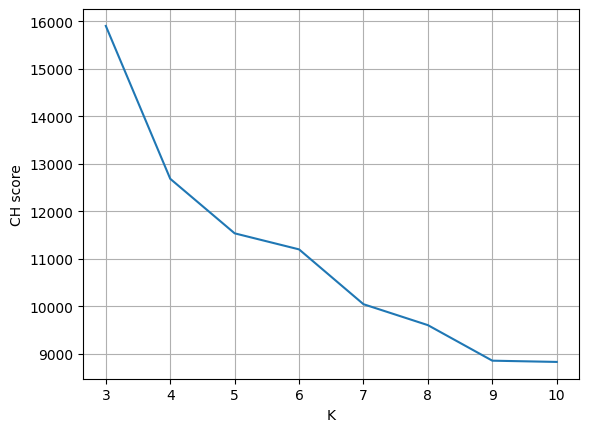

In [41]:
CH = [calinski_harabasz_score(o2vae_embeddings, l) for l in lbls_vae] #calculate CH for each clustering
plt.plot(range(3,11), CH)
plt.xlabel('K')
plt.ylabel('CH score')
plt.grid()

The BIC (AIC) difference curve suggests that 6 or 8 clusters are optimal for the embedded data. DB (in second image) suggest that identifying 8 clusters is slightly better than identifying 6 clusters. However, from the plot of CH scores, we have an opposite suggestion that 6 clustering is infact better. We shall settle for the less complex model, that is 6 clusters.

What follows is a plot of distribution of morphological characteristics of each of the 6 clusters.

Could not extract ID from filename: 0719_316L_3_2240-CE diameter=66.60.bmp (invalid literal for int() with base 10: '2240-CE diameter=66.60')


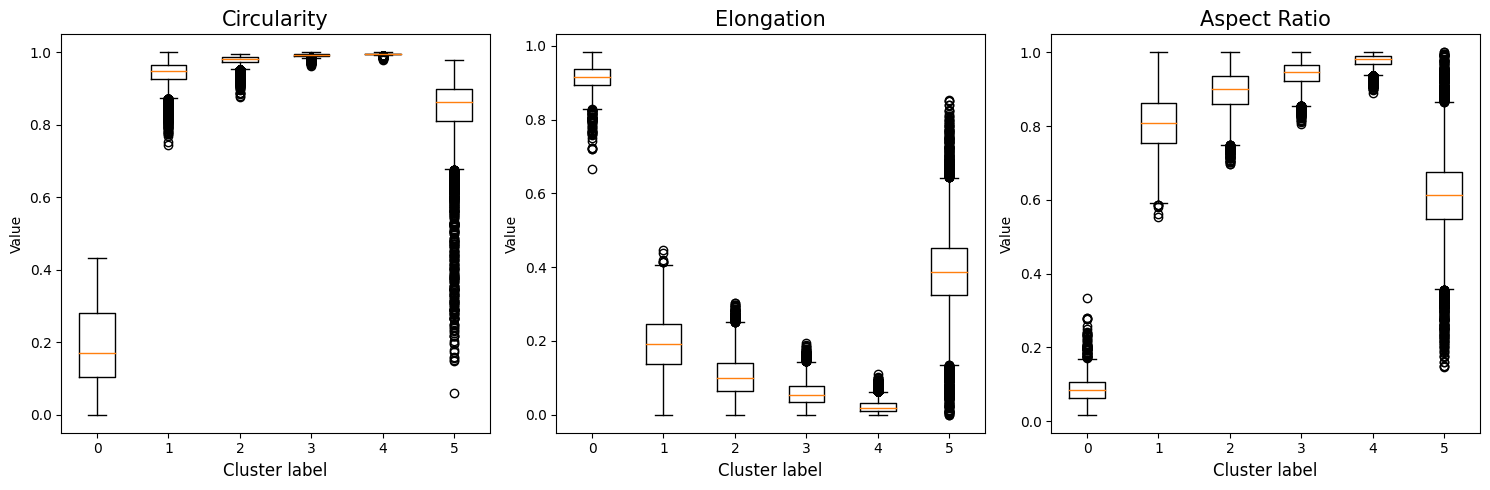

In [31]:
# show the distribution of morphological characteristics each cluster
plot_trad_desc(
    label_path= lbls_vae[3],
    datapath= datapath,
    trad_desc= Path.cwd().parent / '316L-reused' / '316L-reused' / 'test-3 Particles.txt' #path to morphological characteristics measured by Morphologi4
)

# Functional Clustering

Here, the contour of each shape is considered as a function, specifically the centroid distance function. The function `cluster_cdfs` from `GPmix_clustering` module handles this finely. The function applies GPmix which is a functional clustering algorithm to the centroid distance function of the shapes. All that is required is to pass the data path to the function, and it extracts the centroid distance function of all the shapes, and applies GPmix it the dataset.

In [32]:
from GPmix_clustering import cluster_cdfs

Number of representative samples: 6293
Labels ordered by size and saved to GPmix_labels.npy


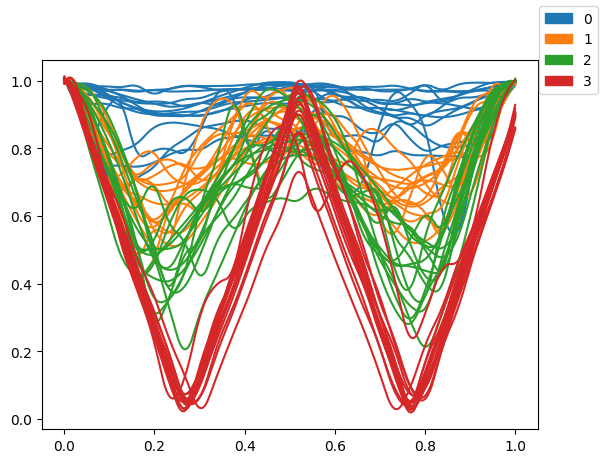

DB score:  0.9110657185471696 CH index:  132861.34879573673


In [33]:
lbl_gpmix = cluster_cdfs(datapath=datapath)

Could not extract ID from filename: 0719_316L_3_2240-CE diameter=66.60.bmp (invalid literal for int() with base 10: '2240-CE diameter=66.60')


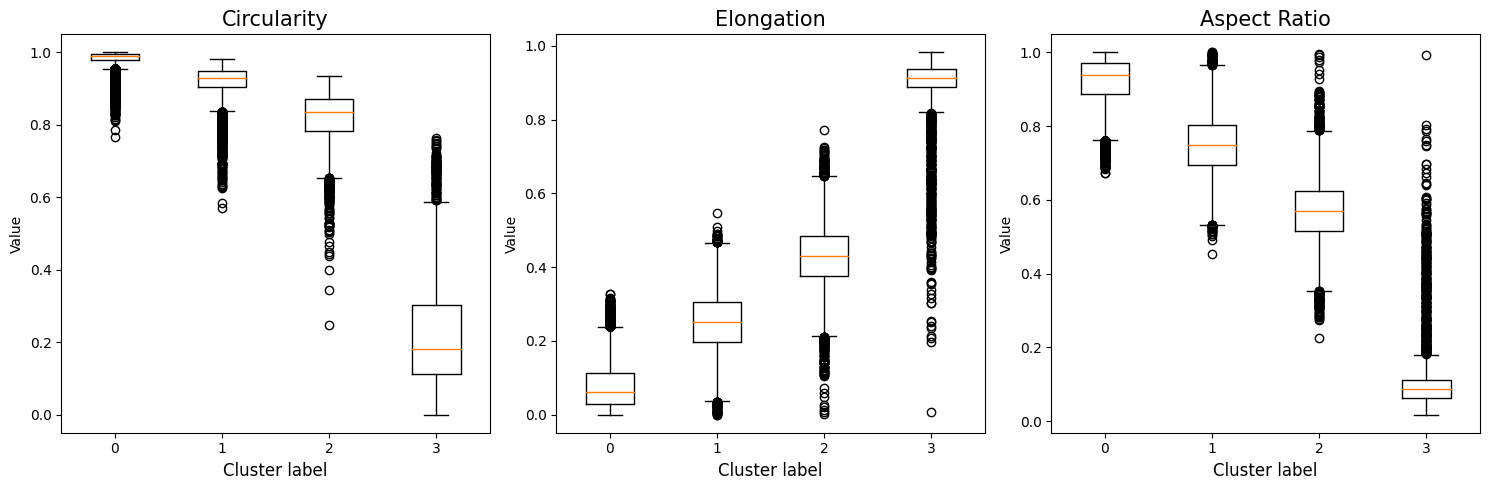

In [34]:
# show the distribution of morphological characteristics each cluster
plot_trad_desc(
    label_path= lbl_gpmix,
    datapath= datapath,
    trad_desc= Path.cwd().parent / '316L-reused' / '316L-reused' / 'test-3 Particles.txt' #path to morphological characteristics measured by Morphologi4
)